In [1]:
from IPython.display import Image

# A Python tutorial on validating gVirtualXRay

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is able to generate analytic simulations on GPU comparable to images generated with the state-of-the-art Monte Caro simulation packages.

**Material and Methods:** To generate an X-ray image with an analytic simulation, we must solve the [Beer-Lambert law](https://en.wikipedia.org/wiki/Beer%E2%80%93Lambert_law), which relies on attenuation coefficients. The first step in validating gVirtualXRay is to ascertain that the attenuation coefficients used in gVirtualXRay are in perfect agreement with those found in the literature. Ground truth data is provided in the [NIST Standard Reference Database 126](https://www.nist.gov/pml/x-ray-mass-attenuation-coefficients).

The second step is to simulate an image with gVirtualXRay and compare it with a ground truth image. For this purpose, we use [Gate],(http://www.opengatecollaboration.org/) a wrapper for CERN's state-of-the-art Monte Caro simulation tool: [Geant4](https://geant4.web.cern.ch/).

In our simulation the source-to-object distance (SOD) is 1000mm, and the source-to-detector distance (SDD) is 1125mm. The beam spectrum is generated using [SpekPy](https://bitbucket.org/spekpy/spekpy_release/wiki/Home). We use a tube voltage of 90kV, which is typical of chest x-ray procedures for a 70kg male patient. The total aluminium equivalent filtration is 3.2mm.

### Simulation parameters

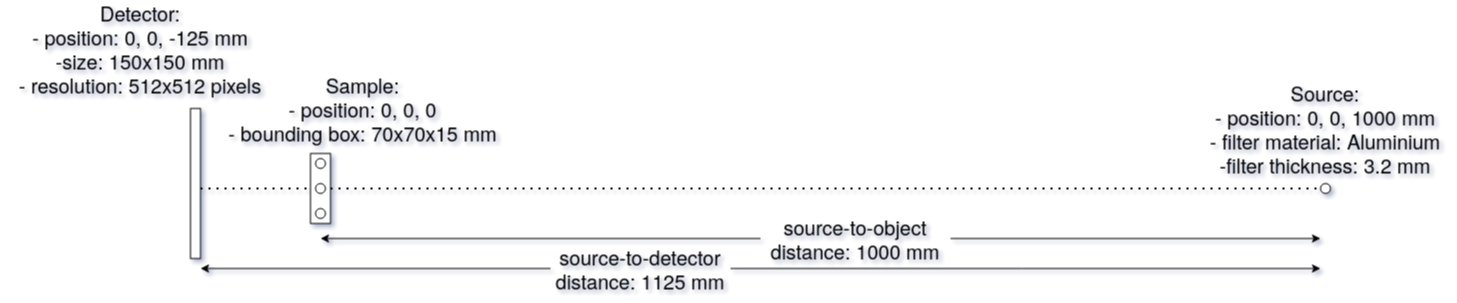

In [2]:
Image("doc/setup.png")

The sample is made of a 70x70x15mm box of water, in which 5 columns of 3 spheres of different radii (2, 3.5, and 5mm) have been inserted. A given material is associated to the spheres of each column (bone (cortical), blood (whole), brain (grey/white matter), breast tissue, and adipose tissue). The columns are ordered in decreasing density. We use the definitions of tissue substitutes provided in the [ICRU Report 44](https://www.icru.org/report/tissue-substitutes-in-radiation-dosimetry-and-measurement-report-44/) by the [International Commission on Radiation Units and Measurements](https://www.icru.org/). The material composition is available at [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html).

### Sample composition

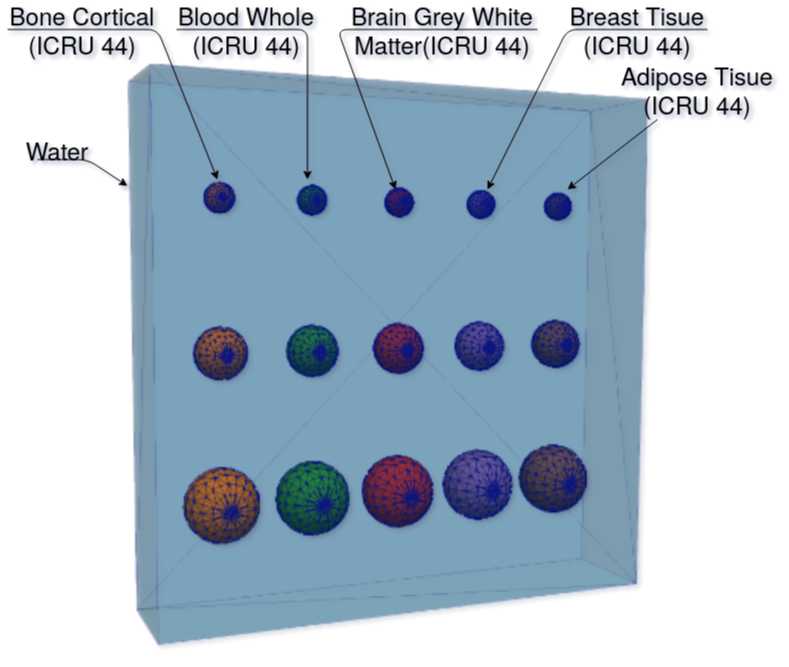

In [3]:
Image("doc/sample.png")

**Results:** The correlation coefficient between the attenuation coefficients computed with gVirtualXRay and those provided in NIST's *XCOM: Photon Cross Sections Database* is 100% for bone (cortical), blood (whole), brain (grey/white matter), breast tissue, and adipose tissue. It demonstrates that the photon cross section calculations performed in gVirtualXRay are accurate. 


The [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), between the two simulated images is ???%. The [zero-mean normalised cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)) is ???%. 
<!-- The [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity) is ???%.  -->
As MAPE is low, and ZNCC is close to 100%, we can conclude that X-ray images simulated with gVirtualXRay on GPU in milliseconds are comparable to Monte Carlo simulations ran on supercomputers for days.

## Import packages

In [4]:
%matplotlib inline

import os # Locate files

import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files

import matplotlib
# old_backend =  matplotlib.get_backend() 
# matplotlib.use("Agg")  # Prevent showing stuff

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
from matplotlib.colors import PowerNorm # Look up table
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

from scipy.stats import pearsonr # Compute the correlatio coefficient

from skimage.util import compare_images # Checkboard comparison between two images
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_percentage_error as mape

from tifffile import imread, imsave # Load/Write TIFF files

import viewscad # Use OpenSCAD to create STL files

import pyvista as pv # 3D visualisation
from pyvista import themes

import cma # Optimise the parameters of the noise model

import gvxrPython3 as gvxr # Simulate X-ray images

import json2gvxr # Set gVirtualXRay and the simulation up

SimpleGVXR 1.0.1 (2021-07-01T17:00:40) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2021-07-01T17:00:40) [Compiler: GNU g++] on Linux


## Reference image

We first load the reference image that has been simulated using [Gate](http://www.opengatecollaboration.org/) wrapper for CERN's [Geant4](https://geant4.web.cern.ch/). Here we ignore scattering.

In [5]:
Image = imread("GATE/output/energy_1e10.tif")
Full_field = imread("GATE/output/energy-total_white.tif")
Dark_field = np.zeros(Full_field.shape)

Projections are then corrected to account for variations in beam homogeneity and in the pixel-to-pixel sensitivity of the detector. This is the projection with flat-field correction ($\mathbf{Proj}$):
\begin{equation}
\mathbf{Proj} = \frac{\boldsymbol{I} - \boldsymbol{D}}{\boldsymbol{F} - \boldsymbol{D}}
\label{eq:flat-fields}
\end{equation}
where $\boldsymbol{F}$ (full fields) and $\boldsymbol{D}$ (dark fields) are projection images without sample and acquired with and without the X-ray beam turned on respectively. 
<!-- Note that with an ideal detector ($\boldsymbol{R}_i=E_i$), pixels of $\boldsymbol{D}$ are null, and pixels of $\boldsymbol{F}$ are equal to $\sum_i E_i \; \boldsymbol{N}_i$. 
 -->

We now apply the flat-field correction to `Image`.

In [6]:
gate_image = (Image - Dark_field) / (Full_field - Dark_field)

gate_image = imread("GATE/output/energy_1e10_flat2.tif")

We plot the image using a linear look-up table and a power-law normalisation.

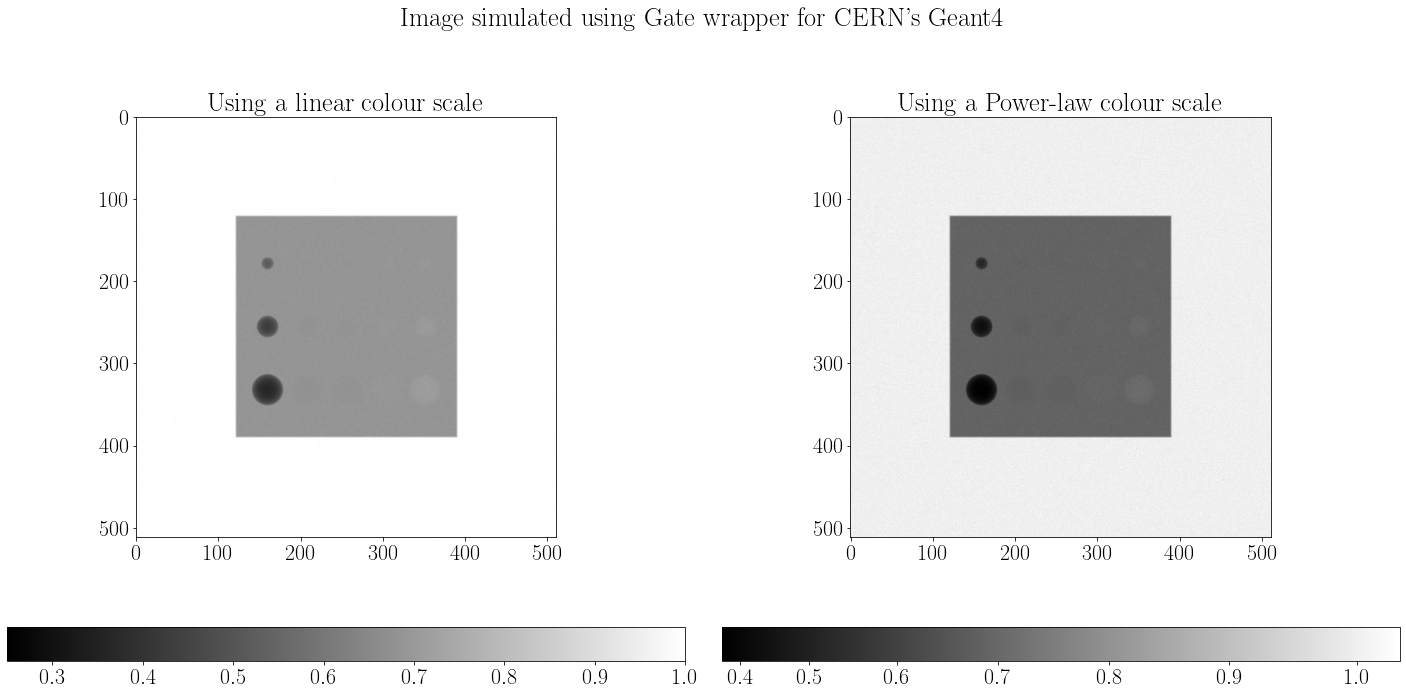

In [7]:
plt.figure(figsize= (20,10))

plt.suptitle("Image simulated using Gate wrapper for CERN's Geant4", y=1.02)

plt.subplot(121)
plt.imshow(gate_image, cmap="gray", vmin=0.25, vmax=1)
plt.colorbar(orientation='horizontal')
plt.title("Using a linear colour scale")

plt.subplot(122)
plt.imshow(gate_image, norm=PowerNorm(gamma=1./0.75), cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a Power-law colour scale")

plt.tight_layout()

plt.savefig('plots/reference_from_Gate.pdf')
plt.savefig('plots/reference_from_Gate.png')

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [8]:
json2gvxr.initGVXR("simulation.json", "OPENGL")

Create an OpenGL context: 800x450
gvxrStatus:	Create window 0
gvxrStatus:	Create window 
0 0 500 500
OpenGL renderer:   NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
OpenGL version:    3.2.0 NVIDIA 470.42.01
OpenGL vender:     NVIDIA Corporation
Use OpenGL 4.5.
0 0 800 450


## X-ray source

We create an X-ray source. It is a point source.

In [9]:
json2gvxr.initSourceGeometry()

Set up the beam
	Source position: [0.0, 0.0, 1000.0, 'mm']
	Source shape: PointSource


## Spectrum

The beam spectrum is generated using [SpekPy](https://bitbucket.org/spekpy/spekpy_release/wiki/Home). We decided to use a beam that is clinically appropriate. The chest phantom we used corresponds to a 70kg male patient. For a male chest x-ray, the tube voltage is in the range 80-120kV depending on technique, pathology and equipment used. The total aluminium equivalent filtration is approximately 3.2mm. `verbose=1` below is used to output the beam spectrum for Gate. To disable it, change it to `verbose=0`.

In [10]:
spectrum, unit, k, f = json2gvxr.initSpectrum(verbose=1)

/gate/source/mybeam/gps/emin 11.0 keV
/gate/source/mybeam/gps/emax 90.0 keV
/gate/source/mybeam/gps/histpoint 0.011 3
/gate/source/mybeam/gps/histpoint 0.0115 12
/gate/source/mybeam/gps/histpoint 0.012 40
/gate/source/mybeam/gps/histpoint 0.0125 148
/gate/source/mybeam/gps/histpoint 0.013 519
/gate/source/mybeam/gps/histpoint 0.0135 1565
/gate/source/mybeam/gps/histpoint 0.014 4090
/gate/source/mybeam/gps/histpoint 0.0145 9474
/gate/source/mybeam/gps/histpoint 0.015 19789
/gate/source/mybeam/gps/histpoint 0.0155 37826
/gate/source/mybeam/gps/histpoint 0.016 67047
/gate/source/mybeam/gps/histpoint 0.0165 111380
/gate/source/mybeam/gps/histpoint 0.017 174907
/gate/source/mybeam/gps/histpoint 0.0175 261254
/gate/source/mybeam/gps/histpoint 0.018 373324
/gate/source/mybeam/gps/histpoint 0.0185 513706
/gate/source/mybeam/gps/histpoint 0.019 684248
/gate/source/mybeam/gps/histpoint 0.0195 885574
/gate/source/mybeam/gps/histpoint 0.02 1116396
/gate/source/mybeam/gps/histpoint 0.0205 1374186
/

In [11]:
print("kvp:", json2gvxr.params["Source"]["Beam"]["kvp"])
print("filter material:", json2gvxr.params["Source"]["Beam"]["filter"][0])
print("filter thickness (in mm):", json2gvxr.params["Source"]["Beam"]["filter"][1])

kvp: 90
filter material: Al
filter thickness (in mm): 3.2


Plot the spectrum

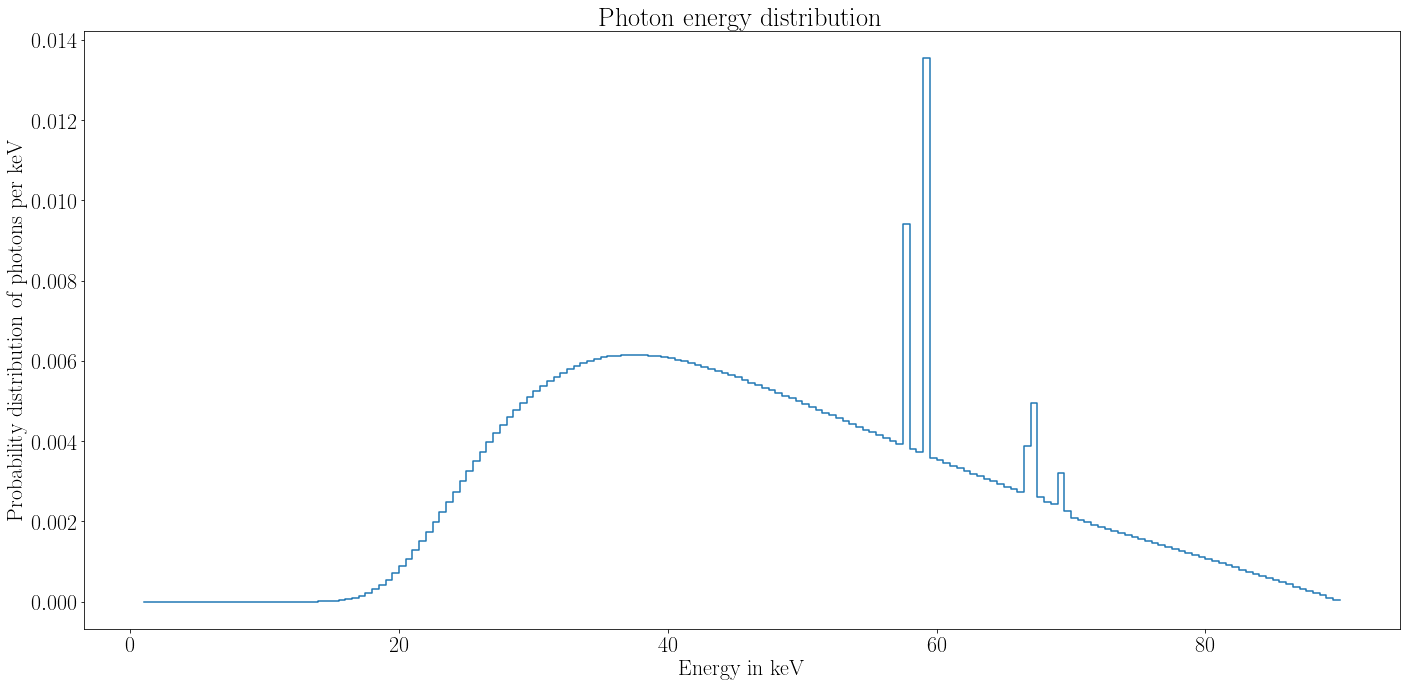

In [12]:
energy_set = sorted(spectrum.keys())
count_set = []

for energy in energy_set:
    count_set.append(spectrum[energy])
    
plt.figure(figsize= (20,10))

plt.plot(k, f / f.sum()) # Plot the spectrum
plt.xlabel('Energy in keV')
plt.ylabel('Probability distribution of photons per keV')
plt.title('Photon energy distribution')

plt.tight_layout()

plt.savefig('plots/spectrum.pdf')
plt.savefig('plots/spectrum.png')

## Detector

Create a digital detector

In [13]:
json2gvxr.initDetector()

Set up the detector
	Detector position: [0.0, 0.0, -125.0, 'mm']
	Detector up vector: [0, 1, 0]
	Detector number of pixels: [512, 512]
	Pixel spacing: [0.29296875, 0.29296875, 'mm']
INIT RENDER


## Sample

We now create CAD models using [OpenSCAD](https://openscad.org/) and extract the corresponding STL files.

In [14]:
openscad_make_spheres_str = """

module make_column_of(sphere_radius, height, count)
{
    step = height / (count - 1);
    for (a = [0 : count - 1]) {
        offset = -height / 2 + step * a ;
        translate([0, offset, 0])
            sphere(sphere_radius[a], $fn=25);
    }
}

module make_row_of(radius, count, id)
{
    step = radius / (count - 1);
    for (a = [0 : count - 1]) {
        if (id == -1 || id == a) {
            offset = -radius / 2 + step * a ;
            translate([offset, 0, 0])
                children();
        }
    }
}

module make_spheres(sphere_radius, ring_radius, ring_count, column_height, column_count, id = -1)
{
    make_row_of(radius = ring_radius, count = ring_count, id = id)
        make_column_of(sphere_radius, height = column_height, count = column_count);
}
"""

The matrix

In [15]:
openscad_matrix_str = """

color("red")
    difference() {
        scale([70, 70, 15])
            cube(1, center = true);
        make_spheres([2, 3.5, 5], 50, 5, 40, 3, -1);
}

"""

In [16]:
r = viewscad.Renderer()
r.render(openscad_matrix_str + openscad_make_spheres_str, outfile='gvxr/input/matrix.stl')

CGAL Cache insert: group(){multmatrix([[1,0,0,0],[0,1,0,-20 (2353608 bytes)
CGAL Cache hit: group(){multmatrix([[1,0,0,0],[0,1,0,-20 (2353608 bytes)
CGAL Cache insert: multmatrix([[1,0,0,-25],[0,1,0,0],[0,0,1 (2353608 bytes)
CGAL Cache hit: group(){multmatrix([[1,0,0,0],[0,1,0,-20 (2353608 bytes)
CGAL Cache insert: multmatrix([[1,0,0,-12.5],[0,1,0,0],[0,0 (2353608 bytes)
CGAL Cache hit: group(){multmatrix([[1,0,0,0],[0,1,0,-20 (2353608 bytes)
CGAL Cache insert: multmatrix([[1,0,0,0],[0,1,0,0],[0,0,1,0 (2353608 bytes)
CGAL Cache hit: group(){multmatrix([[1,0,0,0],[0,1,0,-20 (2353608 bytes)
CGAL Cache insert: multmatrix([[1,0,0,12.5],[0,1,0,0],[0,0, (2353608 bytes)
CGAL Cache hit: group(){multmatrix([[1,0,0,0],[0,1,0,-20 (2353608 bytes)
CGAL Cache insert: multmatrix([[1,0,0,25],[0,1,0,0],[0,0,1, (2353608 bytes)
CGAL Cache insert: group(){multmatrix([[1,0,0,-25],[0,1,0,0 (11767656 bytes)
CGAL Cache hit: group(){multmatrix([[1,0,0,-25],[0,1,0,0 (11767656 bytes)
CGAL Cache insert: differenc

In [17]:
openscad_cube_str = """

color("red")
    scale([70, 70, 15])
        cube(1, center = true);

"""

In [18]:
r = viewscad.Renderer()
r.render(openscad_cube_str, outfile='gvxr/input/cube.stl')

The spheres

In [19]:
openscad_col_str_set = []

for i in range(5):
    openscad_col_str_set.append("""
    color("blue")
        make_spheres([2, 3.5, 5], 50, 5, 40, 3, """ + str(i) + ");")
        
    r = viewscad.Renderer()
    r.render(openscad_col_str_set[-1] + openscad_make_spheres_str, outfile='gvxr/input/col_' + str(i) + '.stl')

CGAL Cache insert: group(){multmatrix([[1,0,0,0],[0,1,0,-20 (2353608 bytes)
CGAL Cache hit: group(){multmatrix([[1,0,0,0],[0,1,0,-20 (2353608 bytes)
CGAL Cache insert: multmatrix([[1,0,0,-25],[0,1,0,0],[0,0,1 (2353608 bytes)
CGAL Cache hit: multmatrix([[1,0,0,-25],[0,1,0,0],[0,0,1 (2353608 bytes)
CGAL Cache hit: multmatrix([[1,0,0,-25],[0,1,0,0],[0,0,1 (2353608 bytes)
CGAL Cache hit: multmatrix([[1,0,0,-25],[0,1,0,0],[0,0,1 (2353608 bytes)
CGAL Cache insert: color([0,0,1,1]){multmatrix([[1,0,0,-25] (2353608 bytes)
CGAL Cache insert: group(){multmatrix([[1,0,0,0],[0,1,0,-20 (2353608 bytes)
CGAL Cache hit: group(){multmatrix([[1,0,0,0],[0,1,0,-20 (2353608 bytes)
CGAL Cache insert: multmatrix([[1,0,0,-12.5],[0,1,0,0],[0,0 (2353608 bytes)
CGAL Cache hit: multmatrix([[1,0,0,-12.5],[0,1,0,0],[0,0 (2353608 bytes)
CGAL Cache hit: multmatrix([[1,0,0,-12.5],[0,1,0,0],[0,0 (2353608 bytes)
CGAL Cache hit: multmatrix([[1,0,0,-12.5],[0,1,0,0],[0,0 (2353608 bytes)
CGAL Cache insert: color([0,0,1,1]){

Load the samples. `verbose=2` is used to print the material database for Gate. To disable it, use `verbose=0` or `verbose=1`.

In [20]:
json2gvxr.initSamples(verbose=2)

Load the 3D data

file_name:	gvxr/input/col_0.stl	nb_faces:	1938	nb_vertices:	5814	bounding_box (in cm):	(-2.99606, -2.19961, -0.496354)	(-2, 2.49901, 0.496354)
Bone_Cortical_ICRU_44: d=1.92 g/cm3 ; n=9 ; state=solid
        +el: name=Hydrogen ; f=0.034
        +el: name=Carbon ; f=0.155
        +el: name=Nitrogen ; f=0.042
        +el: name=Oxygen ; f=0.435
        +el: name=Sodium ; f=0.001
        +el: name=Magnesium ; f=0.002
        +el: name=Phosphor ; f=0.103
        +el: name=Sulfur ; f=0.003
        +el: name=Calcium ; f=0.225

Blood_Whole_ICRU_44: d=1.06 g/cm3 ; n=10 ; state=solid
        +el: name=Hydrogen ; f=0.102
        +el: name=Carbon ; f=0.11
        +el: name=Nitrogen ; f=0.033
        +el: name=Oxygen ; f=0.745
        +el: name=Sodium ; f=0.001
        +el: name=Phosphor ; f=0.001
        +el: name=Sulfur ; f=0.002
        +el: name=Chlorine ; f=0.003
        +el: name=Potassium ; f=0.002
        +el: name=Iron ; f=0.001

Brain_Grey_White_Matter_ICRU_44: d=1.04 g/c

## Mass attenuation coefficients

Before computing an X-ray image, we can check that the mass attenuation coefficients are accurate. We downloaded tabulated data from the XCOM database and compare the values with the ones used in gVirtualXRay. We do it for relevant chemical elements from [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab3.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab3.html):

- [Carbon](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z06.html)
- [Chlorine](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z17.html)
- [Hydrogen](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z01.html)
- [Iron](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z26.html)
- [Magnesium](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z12.html)
- [Nitrogen](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z07.html)
- [Oxygen](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z08.html)
- [Phosphorus](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z15.html)
- [Potassium](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z19.html)
- [Sodium](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z11.html)
- [Sulfur](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z16.html)

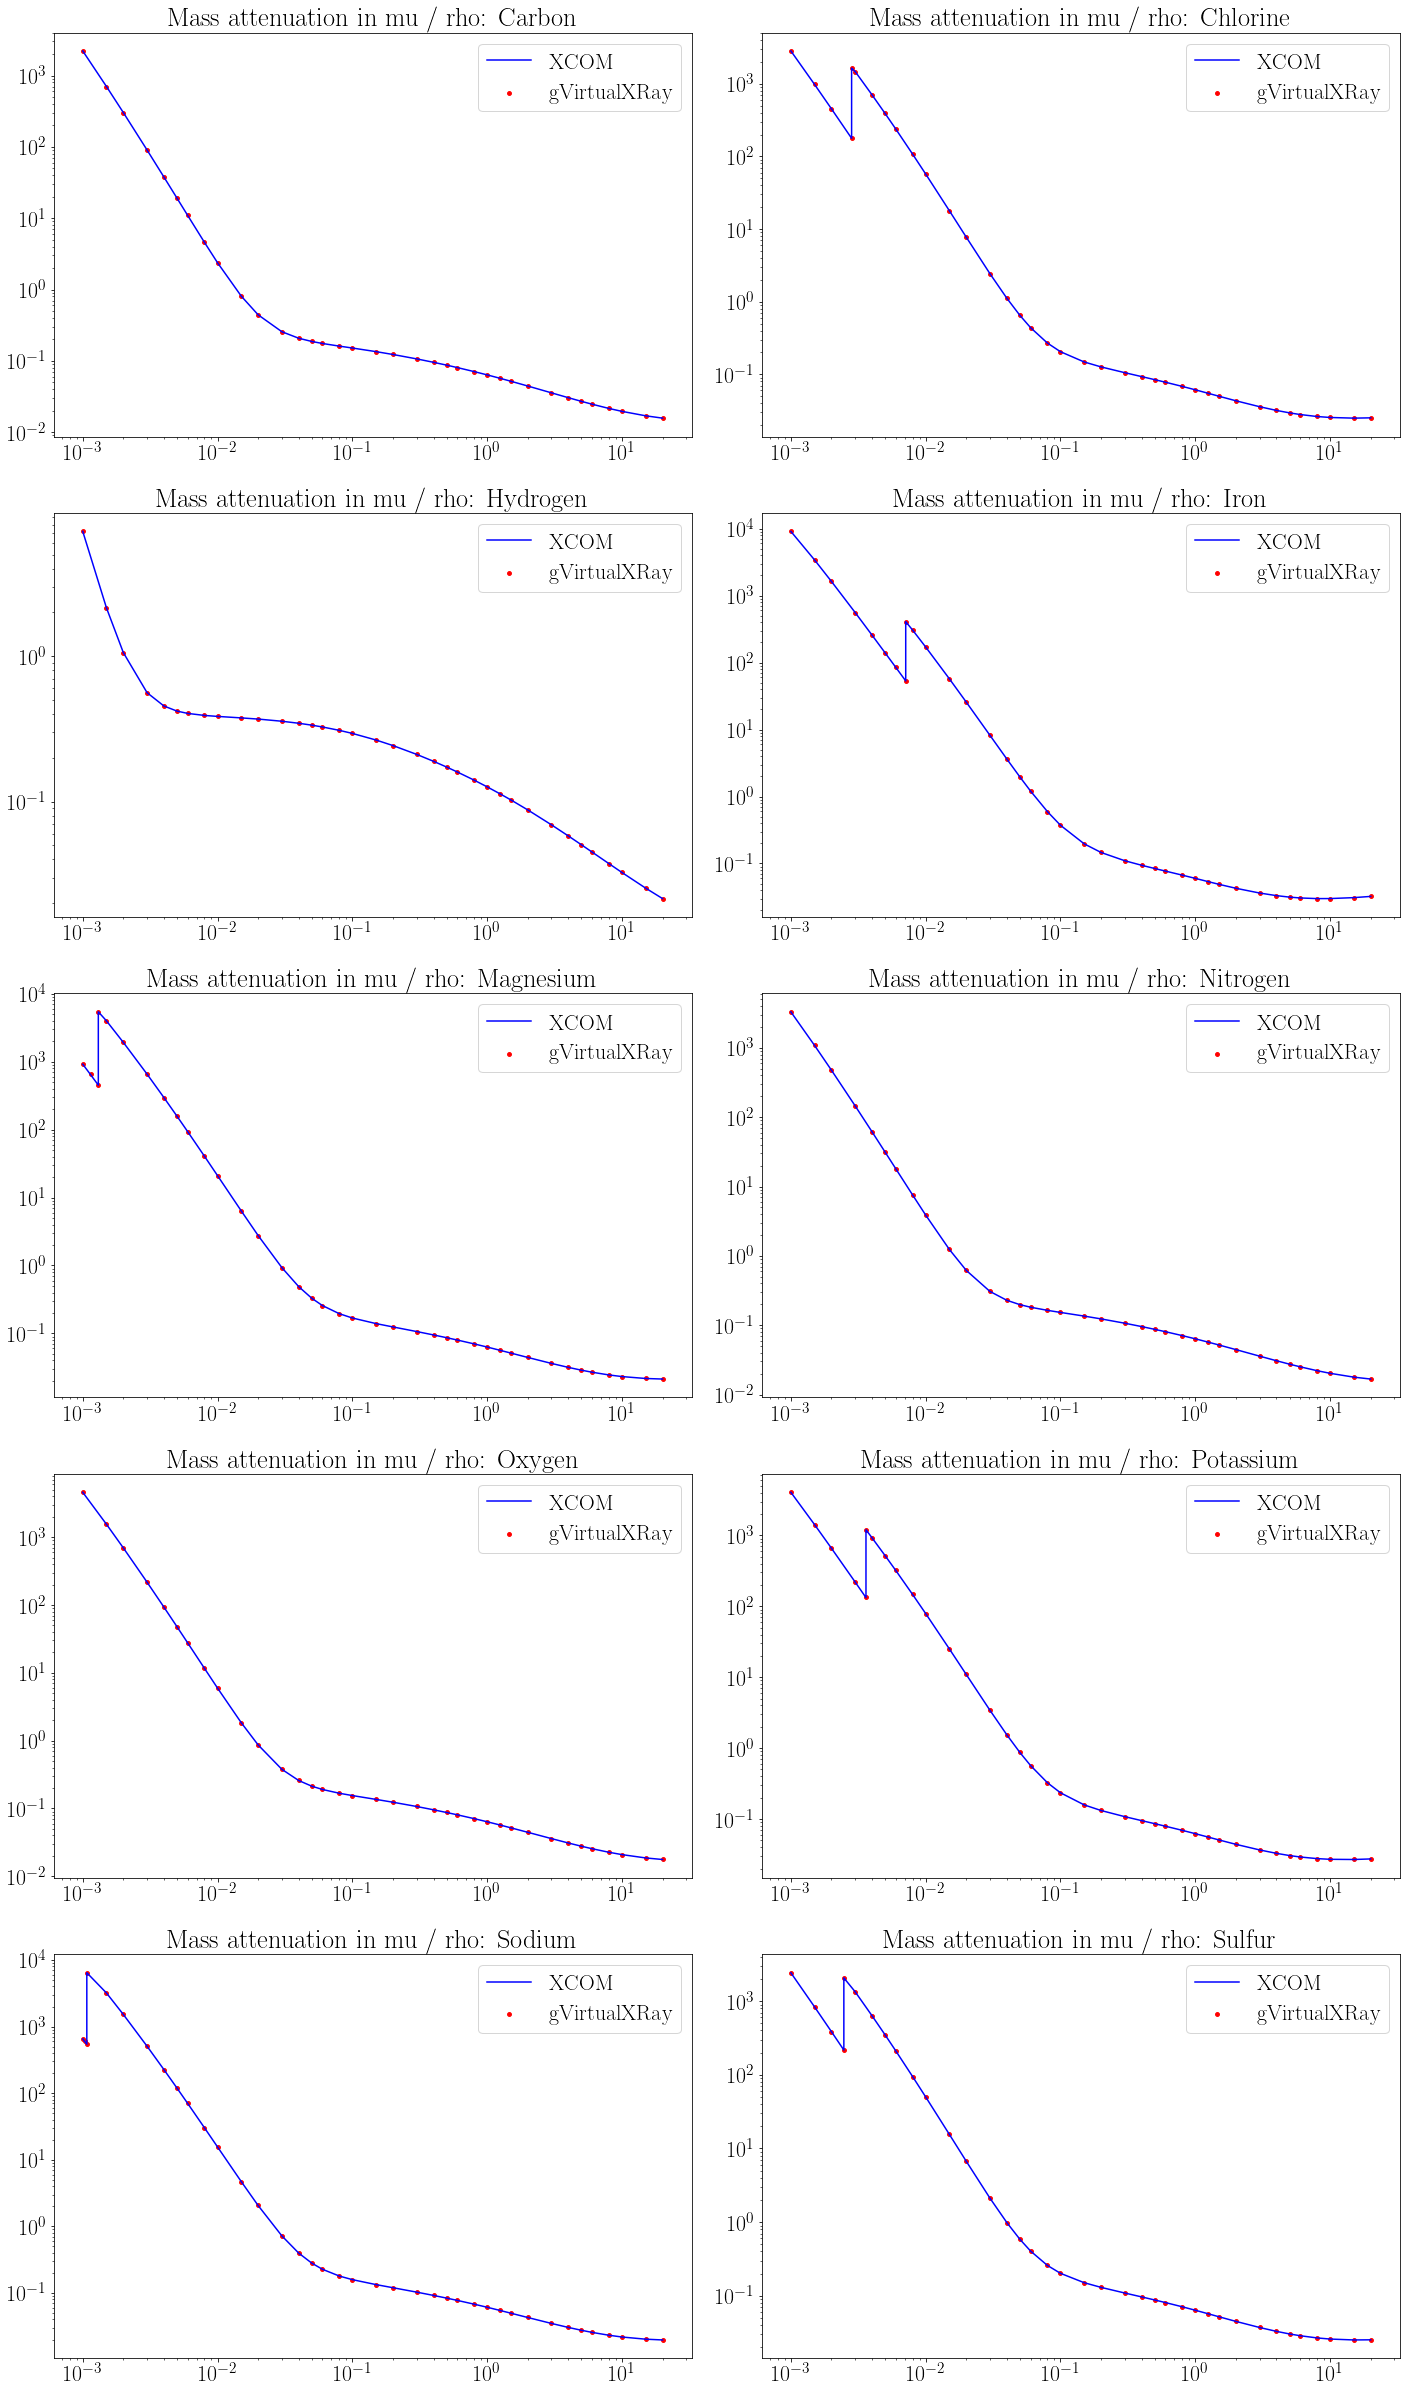

In [21]:
elements = ["Carbon", "Chlorine", "Hydrogen", "Iron", "Magnesium", "Nitrogen", "Oxygen", "Potassium", "Sodium", "Sulfur"] #  "Phosphorus"]#, ]

i = 1

plt.figure(figsize= (20,40))

for element in elements:
    if os.path.isfile("gvxr/input/" + element + ".csv"):
        df = pd.read_csv("gvxr/input/" + element + ".csv")
        
        gvxr_mu_rho = []
        gvxr_energy = []
        for energy_id in range(len(df["Photon in MeV"])):
            if energy_id == len(df["Photon in MeV"]) - 1 or energy_id == 0:
                energy = df["Photon in MeV"][energy_id]
            elif df["Photon in MeV"][energy_id] == df["Photon in MeV"][energy_id + 1]:
                energy = df["Photon in MeV"][energy_id] - df["Photon in MeV"][energy_id] * 1e-3
            elif df["Photon in MeV"][energy_id] == df["Photon in MeV"][energy_id - 1]:
                energy = df["Photon in MeV"][energy_id] + df["Photon in MeV"][energy_id] * 1e-3
            else:
                energy = df["Photon in MeV"][energy_id]
            
            gvxr_mu_rho.append(gvxr.getMassAttenuationFromElement(element, energy, "MeV"))
            gvxr_energy.append(energy)
        
        df["Mass attenuation coefficient (gVirtualXRay)"] = gvxr_mu_rho
        df["|XCOM - gVirtualXRay| / XCOM (in %)"] = np.abs(np.array(100 * (df["Mass attenuation coefficient"] - gvxr_mu_rho) / df["Mass attenuation coefficient"])).astype(int)
        
        if df["|XCOM - gVirtualXRay| / XCOM (in %)"].mean() > 1.0:
            print("\tWARNING:")
            print("\t\tAverage:", df["|XCOM - gVirtualXRay| / XCOM (in %)"].mean())
            print("\t\tMax:", df["|XCOM - gVirtualXRay| / XCOM (in %)"].abs().max())
        
        df.to_csv("gvxr/output/" + element + "-validation.csv", index=False )
        
        plt.subplot(6, 2, i)
        plt.title("Mass attenuation in mu / rho:  " + element)
        plt.plot(df["Photon in MeV"], df["Mass attenuation coefficient"], label="XCOM", color="b")
        plt.scatter(gvxr_energy, gvxr_mu_rho, label="gVirtualXRay", s=15, color="r")
        plt.legend()
        plt.xscale('log')
        plt.yscale('log')
        
        i = i + 1
        
plt.tight_layout()

plt.savefig('plots/mass_attenuation_coefficients_from_elements.pdf')
plt.savefig('plots/mass_attenuation_coefficients_from_elements.png')

We cannot tell the difference between the data from the XCOM's website and the data genrated using gVirtualXRay. We can now try something more complex, some clinically relevant materials from [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab4.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab4.html):

- [Adipose Tissue (ICRU-44)](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/adipose.html)
- [Blood, Whole (ICRU-44)](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/blood.html)
- [Bone, Cortical (ICRU-44)](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/bone.html)
- [Brain, Grey/White Matter (ICRU-44)](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/brain.html)
- [Breast Tissue (ICRU-44)](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/breast.html)
- [Water, Liquid](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/water.html)

Bone_Cortical_ICRU_44's Pearsons correlation: 99.97%
Bone_Cortical_ICRU_44's MAPE: 0.50%
Blood_Whole_ICRU_44's Pearsons correlation: 99.99%
Blood_Whole_ICRU_44's MAPE: 1.06%
Brain_Grey_White_Matter_ICRU_44's Pearsons correlation: 99.99%
Brain_Grey_White_Matter_ICRU_44's MAPE: 0.64%
Breast_Tissue_ICRU_44's Pearsons correlation: 99.99%
Breast_Tissue_ICRU_44's MAPE: 0.91%
Adipose_Tissue_ICRU_44's Pearsons correlation: 99.99%
Adipose_Tissue_ICRU_44's MAPE: 0.73%
H2O's Pearsons correlation: 100.00%
H2O's MAPE: 0.06%


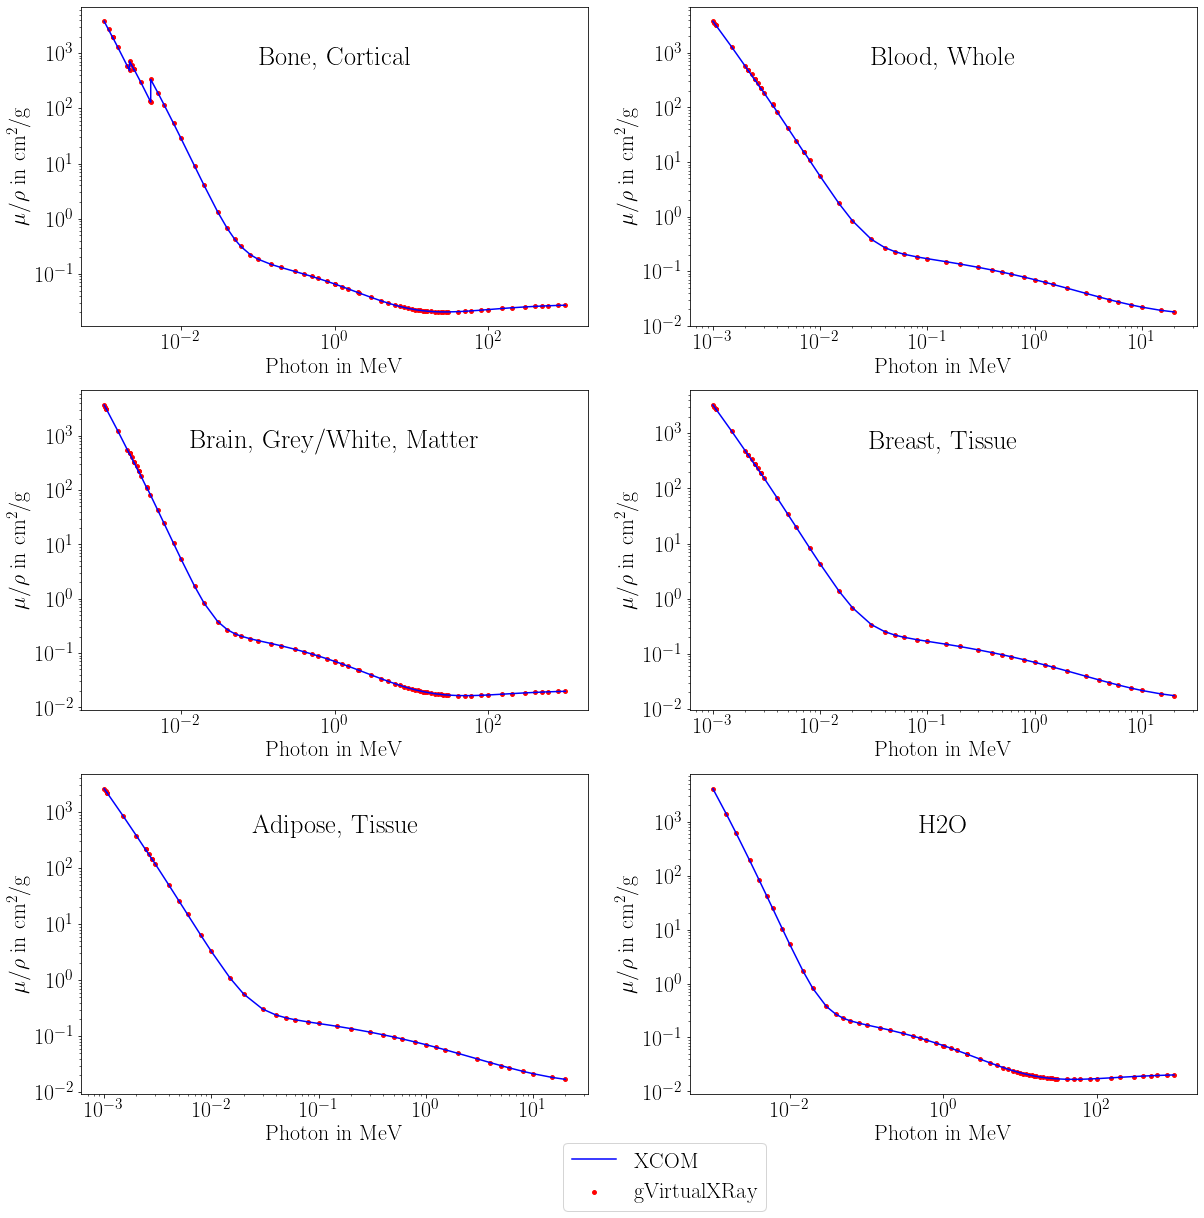

In [22]:
i = 1

plt.figure(figsize= (20,20))

min_pearsons_correlation = 100.0 # initialise with the largest possible value, +100%
max_MAPE = -100.0 # initialise with the smallest possible value, -100%

for sample in json2gvxr.params["Samples"]:
    label = sample["Label"]
    if os.path.isfile("gvxr/input/" + label + ".csv"):
        df = pd.read_csv("gvxr/input/" + label + ".csv")
        
        gvxr_mu_rho = []
        gvxr_energy = []

        for energy_id in range(len(df["Photon in MeV"])):
            if energy_id == len(df["Photon in MeV"]) - 1 or energy_id == 0:
                energy = df["Photon in MeV"][energy_id]
            elif df["Photon in MeV"][energy_id] == df["Photon in MeV"][energy_id + 1]:
                energy = df["Photon in MeV"][energy_id] - df["Photon in MeV"][energy_id] * 1e-3
            elif df["Photon in MeV"][energy_id] == df["Photon in MeV"][energy_id - 1]:
                energy = df["Photon in MeV"][energy_id] + df["Photon in MeV"][energy_id] * 1e-3
            else:
                energy = df["Photon in MeV"][energy_id]

            gvxr_mu_rho.append(gvxr.getMassAttenuationCoefficient(label, energy, "MeV"))
            gvxr_energy.append(energy)

        
        df["Mass attenuation coefficient (gVirtualXRay)"] = gvxr_mu_rho
        df["|XCOM - gVirtualXRay| / XCOM (in %)"] = np.abs(np.array(100 * (df["Mass attenuation coefficient"] - gvxr_mu_rho) / df["Mass attenuation coefficient"])).astype(int)
        
        if df["|XCOM - gVirtualXRay| / XCOM (in %)"].mean() > 1.0:
            print("\tWARNING:")
            print("\t\tAverage:", df["|XCOM - gVirtualXRay| / XCOM (in %)"].mean())
            print("\t\tMax:", df["|XCOM - gVirtualXRay| / XCOM (in %)"].abs().max())

        df.to_csv("gvxr/output/" + label + "-validation.csv", index=False)
        
        plt.subplot(3, 2, i)
        plt.title(label.replace('_ICRU_44','').replace('Grey_White','Grey/White').replace('_',', '), y=0.80)
        plt.plot(df["Photon in MeV"], df["Mass attenuation coefficient"], label="XCOM", color="b")
        plt.scatter(gvxr_energy, gvxr_mu_rho, label="gVirtualXRay", s=15, color="r")
        plt.xlabel('Photon in MeV')
        plt.ylabel('${\\mu}/{\\rho}$ in cm$^2$/g')
        plt.xscale('log')
        plt.yscale('log')
        
        corr, _ = pearsonr(df["Mass attenuation coefficient"], gvxr_mu_rho)
        MAPE = mape(df["Mass attenuation coefficient"], gvxr_mu_rho)

        min_pearsons_correlation = min(min_pearsons_correlation, 100.0 * corr)
        max_MAPE = max(max_MAPE, 100.0 * MAPE)

        print(label + '\'s Pearsons correlation: %.2f' % (100 * corr) + "%")
        print(label + '\'s MAPE: %.2f' % (100 * MAPE) + "%")
        
        if i == 5:
            plt.legend(loc='lower center', bbox_to_anchor=(0.9, -0.4, 0.5, 0.5))

        i = i + 1
        

# plt.tight_layout()

plt.savefig('plots/mass_attenuation_coefficients_from_ICRU44.pdf')
plt.savefig('plots/mass_attenuation_coefficients_from_ICRU44.png')

In [23]:
print("The smallest Pearsons correlation is", str(min_pearsons_correlation) + "%")
print("The largest MAPE is", str(max_MAPE) + "%")

The smallest Pearsons correlation is 99.9680929533951%
The largest MAPE is 1.0550228834256588%


The smallest Pearsons correlation is almost 100%, it is as good as it can get. The largest MAPE is about 1%, which is an extremely small error.

## Runing the simulation

Update the 3D visualisation and take a screenshot

In [24]:
gvxr.displayScene()

gvxr.useLighing()
gvxr.useWireframe()
gvxr.setZoom(719.6787109375)
gvxr.setSceneRotationMatrix([0.7624880075454712, 0.09040657430887222, -0.6406543850898743, 0.0,
                             0.05501500517129898, 0.9775413870811462, 0.20342488586902618, 0.0,
                             0.6446591019630432, -0.190354123711586, 0.7403913140296936, 0.0,
                             0.0, 0.0, 0.0, 1.0])

gvxr.displayScene()

0 0 500 500
0 0 800 450


In [25]:
screenshot = gvxr.takeScreenshot()

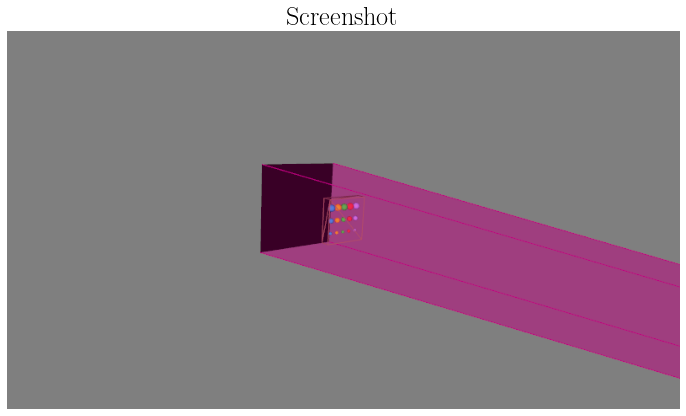

In [26]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/screenshot-beam-off.pdf')
plt.savefig('plots/screenshot-beam-off.png')

Compute an X-ray image and add it to the list of projections

In [27]:
x_ray_image = np.array(gvxr.computeXRayImage())

Normalise the data

In [28]:
total_energy = 0.0
for energy, count in zip(energy_set, count_set):
    total_energy += energy * count

In [29]:
white = np.ones(x_ray_image.shape) * total_energy / 1000.0
dark = np.zeros(x_ray_image.shape)

x_ray_image = (x_ray_image - dark) / (white - dark)

Save the corresponding image

In [30]:
imsave('gvxr/output/projection.tif', x_ray_image.astype(np.single))

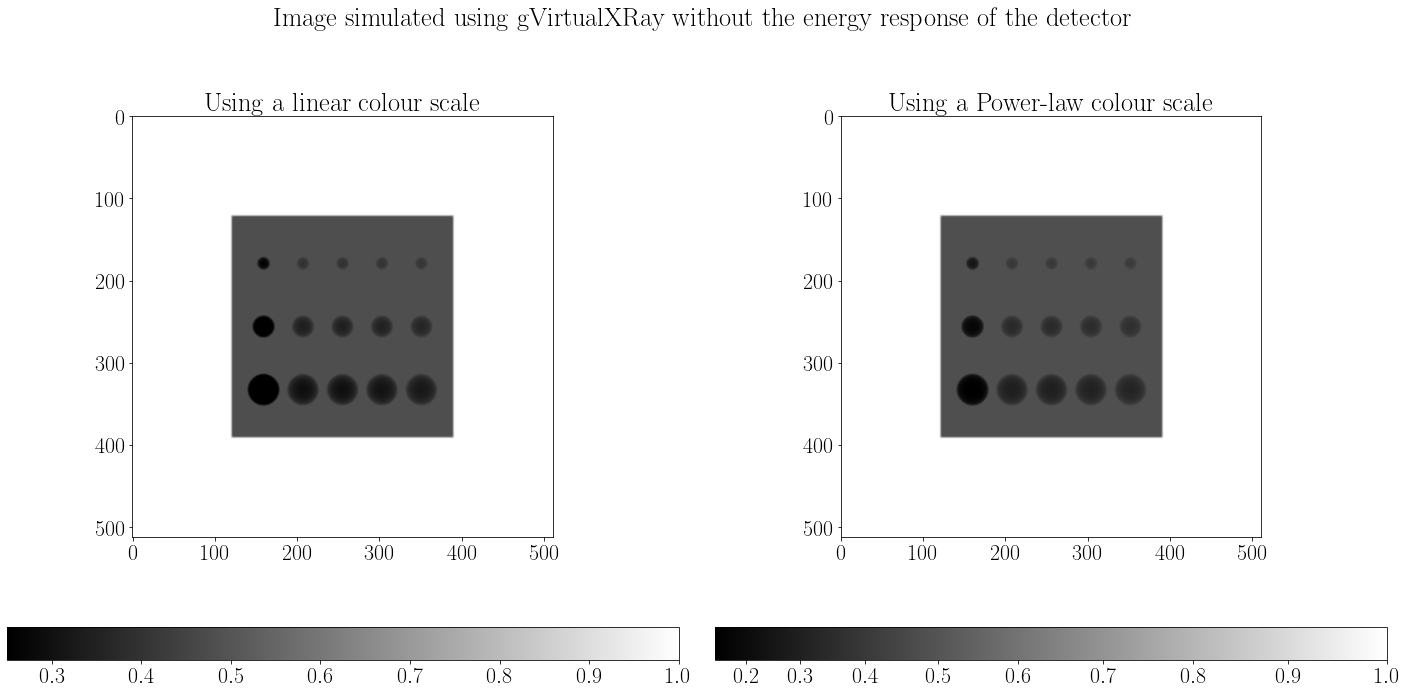

In [31]:
plt.figure(figsize= (20,10))

plt.suptitle("Image simulated using gVirtualXRay without the energy response of the detector", y=1.02)

plt.subplot(121)
plt.imshow(x_ray_image, cmap="gray", vmin=0.25, vmax=1)
plt.colorbar(orientation='horizontal')
plt.title("Using a linear colour scale")

plt.subplot(122)
plt.imshow(x_ray_image, norm=PowerNorm(gamma=1./0.75), cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a Power-law colour scale")

plt.tight_layout()

plt.savefig('plots/x_ray_image_without_detector_response.pdf')
plt.savefig('plots/x_ray_image_without_detector_response.png')

## Compute the L-buffers then the energy fluence

Compute the L-buffers

In [32]:
NoneType = type(None)
import copy

L_buffer_set = {}

L_buffer_inner = None
L_buffer_outer = None

gvxr.disableArtefactFiltering() # Missing the spheres
gvxr.enableArtifactFilteringOnCPU() # Missing the spheres

gvxr.enableArtifactFilteringOnGPU() # Missing the spheres + negative


for sample in json2gvxr.params["Samples"]:
    L_buffer_set[sample["Label"]] = np.array(gvxr.computeLBuffer(sample["Label"]))
    
    if sample["Type"] == "inner":
        
        if isinstance(L_buffer_inner, NoneType):
            L_buffer_inner = copy.deepcopy(L_buffer_set[sample["Label"]])
        else:
            L_buffer_inner += L_buffer_set[sample["Label"]]
    else:
        L_buffer_outer = sample["Label"]

if not isinstance(L_buffer_outer, NoneType):
    L_buffer_set[L_buffer_outer] -= L_buffer_inner

Integrate the energy for every energy channe

In [33]:
x_ray_image_manual = np.zeros(x_ray_image.shape)

for energy, count in zip(energy_set, count_set):

    mu_x = np.zeros(x_ray_image.shape)

    for sample in json2gvxr.params["Samples"]:
        mu = gvxr.getLinearAttenuationCoefficient(sample["Label"], energy, "keV")
        mu_x += L_buffer_set[sample["Label"]] * mu

    x_ray_image_manual += (energy * count) * np.exp(-mu_x)

Normalise the data

In [34]:
x_ray_image_manual = (x_ray_image_manual - dark) / (white * 1000 - dark)

Save the corresponding image

In [35]:
imsave('gvxr/output/projection_manual.tif', x_ray_image_manual.astype(np.single))

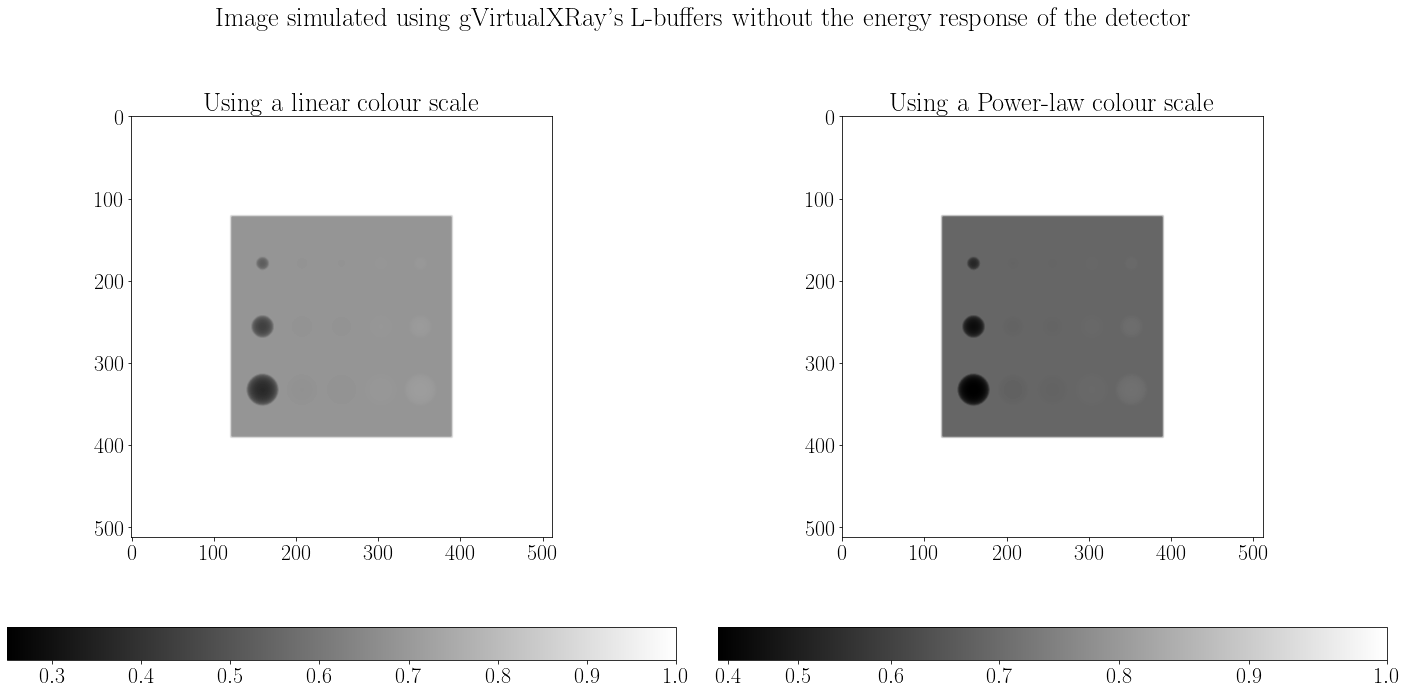

In [36]:
plt.figure(figsize= (20,10))

plt.suptitle("Image simulated using gVirtualXRay's L-buffers without the energy response of the detector", y=1.02)

plt.subplot(121)
plt.imshow(x_ray_image_manual, cmap="gray", vmin=0.25, vmax=1)
plt.colorbar(orientation='horizontal')
plt.title("Using a linear colour scale")

plt.subplot(122)
plt.imshow(x_ray_image_manual, norm=PowerNorm(gamma=1./0.75), cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a Power-law colour scale")

plt.tight_layout()

plt.savefig('plots/x_ray_image_without_detector_response.pdf')
plt.savefig('plots/x_ray_image_without_detector_response.png')

## Model the energy response of the detector

Load the energy response

In [37]:
detector_response = np.loadtxt("GATE/data/responseDetector.txt")

Display the energy response

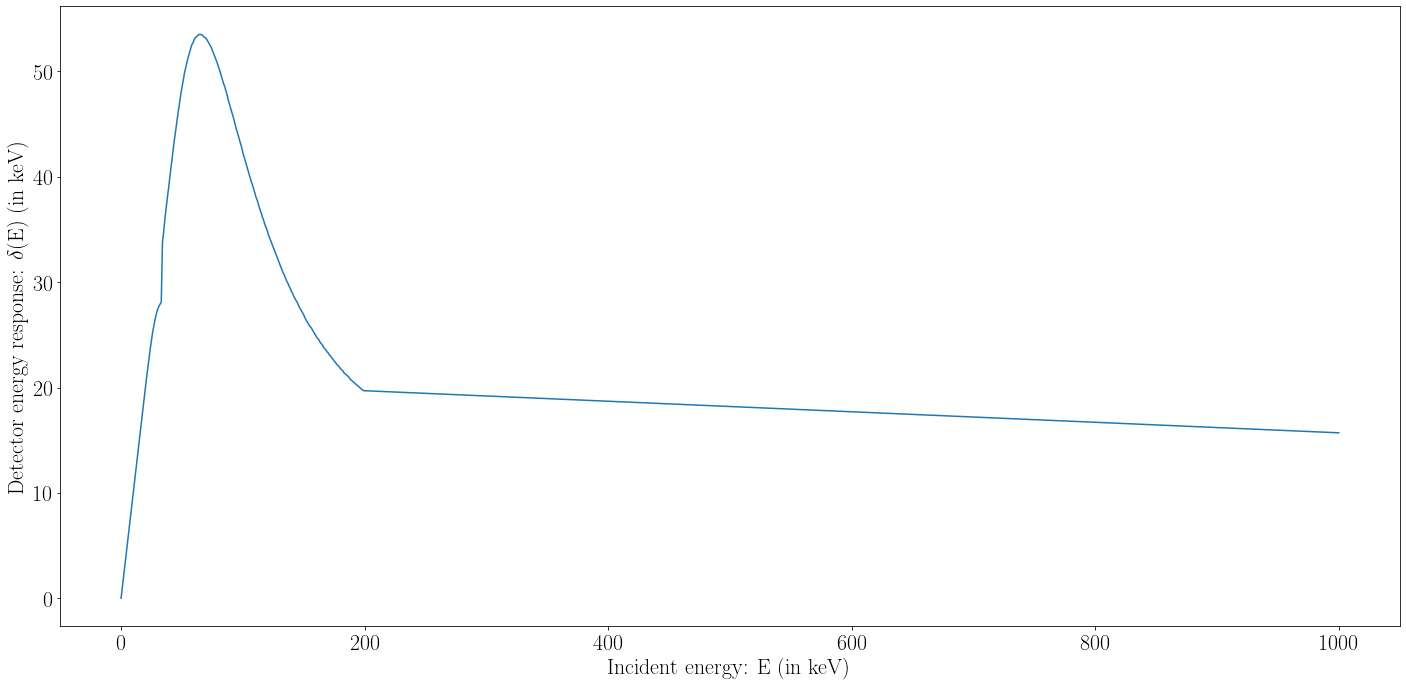

In [38]:
plt.figure(figsize= (20,10))
# plt.title("Detector response")
plt.plot(detector_response[:,0] * 1000, detector_response[:,1] * 1000)
plt.xlabel('Incident energy: E (in keV)')
plt.ylabel('Detector energy response: $\\delta$(E) (in keV)')

plt.tight_layout()

plt.savefig('plots/detector_response.pdf')
plt.savefig('plots/detector_response.png')

Integrate the energy for every energy channe

In [39]:
def interpolate(a_low, a_high, a0, b_low, b_high):
    return b_low + (b_high - b_low) * (a0 - a_low) / (a_high - a_low)

def find_nearest(a, a0, b):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    
    # a[idx] <= a0 <= a[idx+1]
    if a[idx] < a0:
        return interpolate(a[idx], a[idx + 1], a0, b[idx], b[idx + 1])
    # a[idx - 1] <= a0 <= a[idx]
    else:
        return interpolate(a[idx - 1], a[idx], a0, b[idx - 1], b[idx])

In [40]:
x_ray_image_response = np.zeros(x_ray_image.shape)

for energy, count in zip(energy_set, count_set):

    mu_x = np.zeros(x_ray_image.shape)

    for sample in json2gvxr.params["Samples"]:
        mu = gvxr.getLinearAttenuationCoefficient(sample["Label"], energy, "keV")
        mu_x += L_buffer_set[sample["Label"]] * mu

    corrected_energy = find_nearest(detector_response[:,0], energy / 1000, detector_response[:,1])

    x_ray_image_response += (corrected_energy * count) * np.exp(-mu_x)

Compute the full field image with the energy response of the detector

In [41]:
total_energy = 0.0
for energy, count in zip(energy_set, count_set):
    corrected_energy = find_nearest(detector_response[:,0], energy / 1000, detector_response[:,1])
    total_energy += corrected_energy * count
    
white = np.ones(dark.shape) * total_energy

Normalise the data

In [42]:
x_ray_image_response = (x_ray_image_response - dark) / (white - dark)

Save the corresponding image

In [43]:
imsave('gvxr/output/x_ray_image_response.tif', x_ray_image_response.astype(np.single))

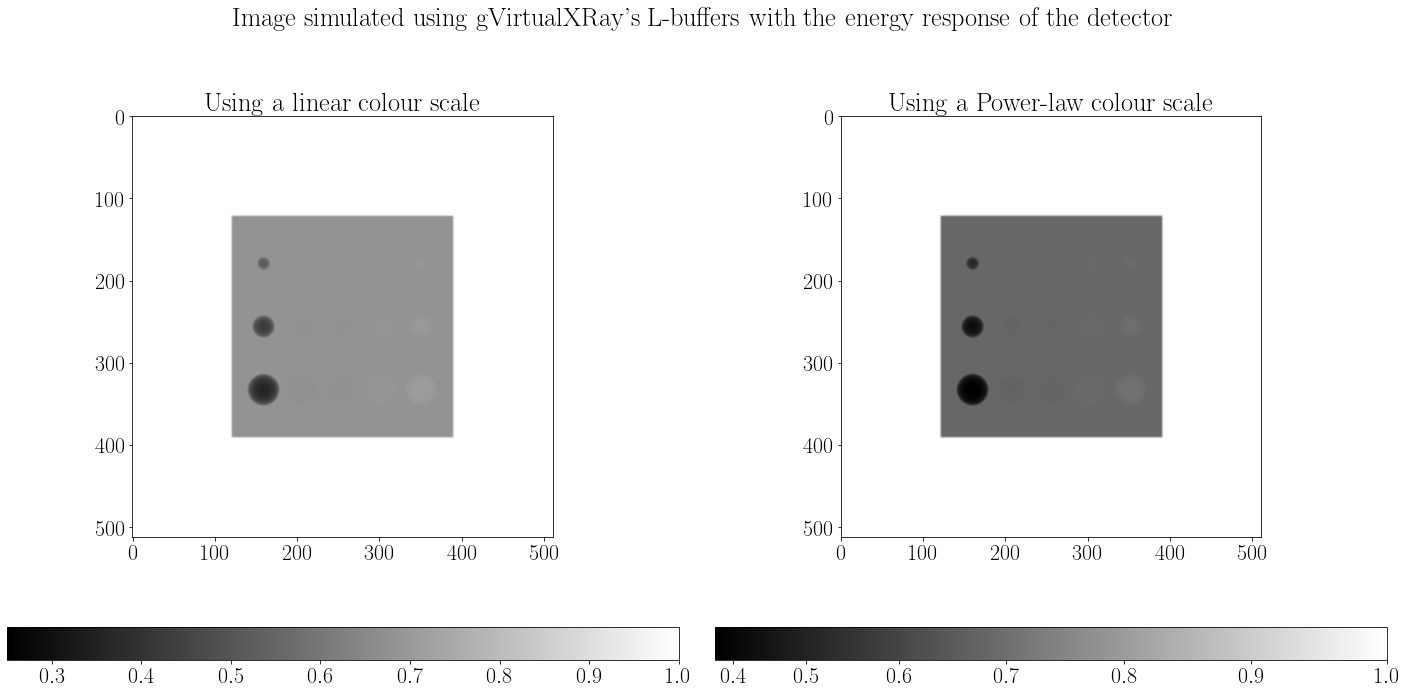

In [44]:
plt.figure(figsize= (20,10))

plt.suptitle("Image simulated using gVirtualXRay's L-buffers with the energy response of the detector", y=1.02)

plt.subplot(121)
plt.imshow(x_ray_image_response, cmap="gray", vmin=0.25, vmax=1)
plt.colorbar(orientation='horizontal')
plt.title("Using a linear colour scale")

plt.subplot(122)
plt.imshow(x_ray_image_response, norm=PowerNorm(gamma=1./0.75), cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a Power-law colour scale")

plt.tight_layout()

plt.savefig('plots/x_ray_image_with_detector_response.pdf')
plt.savefig('plots/x_ray_image_with_detector_response.png')

# Poisson noise

gVirtualXRay exploits the Beer-Lambert law. It does not take into account photon noise. We can, however, estimate the amount of noise in the Monte Carlo simulation and replicate it. First we need to build a model of the Poisson noise:

In [45]:
def applyNoise(img, bias, gain, scale):
    
    # Poisson noise
    temp_xray_image = (img + (bias + 1)) * gain
    temp = np.random.poisson(temp_xray_image).astype(np.single)
    temp /= gain
    temp -= bias + 1

    # Noise map
    noise_map = img - temp
    noise_map *= scale;
    noisy_image = img + noise_map
    
    return noisy_image

We compute the standard deviation of the pixel values in a region of interest (ROI) extracted from the image simulated by Monte Carlo. The ROI does not contain any object.

In [46]:
def getRoiStdDev(img):
    
    ROI_stddev = 0.0
    for y in range(img.shape[0]):
        ROI_stddev += img[y].std()
    ROI_stddev /= img.shape[0];

    return ROI_stddev

In [47]:
# Extract a ROI from the reference image where no object is
reference_noise_ROI = copy.deepcopy(gate_image[0:117,0:117])

min_noise_value = np.min(reference_noise_ROI)
max_noise_value = np.max(reference_noise_ROI)
mean_noise_value = np.mean(reference_noise_ROI)
stddev_noise_value = np.std(reference_noise_ROI)

roi_stddev = getRoiStdDev(reference_noise_ROI)

print("min_noise_value", min_noise_value)
print("max_noise_value", max_noise_value)
print("mean_noise_value", mean_noise_value)
print("stddev_noise_value", stddev_noise_value)
print("roi_stddev", roi_stddev)

min_noise_value 0.9691573
max_noise_value 1.0304549
mean_noise_value 1.0000235
stddev_noise_value 0.007514122
roi_stddev 0.0074658113746688915


We create an objective function that will optimise the parameters of our noise model:

In [48]:
def fitnessFunctionNoise(x):
    global roi_stddev
    global x_ray_image_response
    
    bias = x[0]
    gain = x[1]
    scale = x[2]
    
    # Extract a ROI from the test image where no object is
    test_noise_ROI = copy.deepcopy(x_ray_image_response[0:117,0:117])

    # Apply the noise model
    noisy_image = applyNoise(test_noise_ROI, bias, gain, scale)
        
    # Compute the standard deviation of the pixel values in the ROI extracted from the simulated image with noise
    stddev = getRoiStdDev(noisy_image)

    # Difference of std dev between the reference and the simulated image
    diff = roi_stddev - stddev
    objective = diff * diff

    return objective

We minimise the objective value using a global optimisation algorithm

In [ ]:
# Initialise the values
bias = 0.0;
gain = 255.0;
scale = 1;

x0 = [bias, gain, scale];

bounds = [
    [-1.0,   0.0, -255.0],
    [ 5.0, 255.0, 255.0]
];

opts = cma.CMAOptions()
opts.set('tolfun', 1e-20);
opts['tolx'] = 1e-20;
opts['bounds'] = bounds;
opts['CMA_stds'] = [1, 10, 10];

es = cma.CMAEvolutionStrategy(x0, 0.25, opts);
es.optimize(fitnessFunctionNoise);

bias = es.result.xbest[0];
gain = es.result.xbest[1];
scale = es.result.xbest[2];

# Release memory
del es;

(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=561663, Mon Sep 13 12:28:42 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 9.485801612849184e-05 1.0e+00 2.50e-01  3e-01  3e+00 0:00.0
    2     14 4.359729897409202e-03 1.3e+00 2.73e-01  3e-01  3e+00 0:00.1
    3     21 1.249840681957063e-03 1.8e+00 2.20e-01  2e-01  3e+00 0:00.1
  100    700 4.777586579211975e-11 2.9e+03 7.98e-03  6e-05  1e-01 0:01.9
  200   1400 1.729375377652329e-10 1.6e+03 7.69e-03  7e-06  2e-03 0:03.8
  300   2100 4.915384668987929e-11 4.7e+03 1.17e-03  5e-08  4e-05 0:05.6


In [ ]:
print("bias:", bias)
print("gain:", gain)
print("scale:", scale)

Apply the noise to the simulated image

In [ ]:
noisy_x_ray_image_response = applyNoise(x_ray_image_response, bias, gain, scale)

In [ ]:
# Extract a ROI from the reference image where no object is
test_noise_ROI = copy.deepcopy(noisy_x_ray_image_response[0:117,0:117])

min_noise_value = np.min(test_noise_ROI)
max_noise_value = np.max(test_noise_ROI)
mean_noise_value = np.mean(test_noise_ROI)
stddev_noise_value = np.std(test_noise_ROI)

roi_stddev = getRoiStdDev(test_noise_ROI)

print("min_noise_value", min_noise_value)
print("max_noise_value", max_noise_value)
print("mean_noise_value", mean_noise_value)
print("stddev_noise_value", stddev_noise_value)
print("roi_stddev", roi_stddev)

In [ ]:
plt.figure()
plt.imshow(noisy_x_ray_image_response, cmap="gray", vmin=0.25, vmax=1)
plt.show()

Save the corresponding image

In [ ]:
imsave('gvxr/output/noisy_x_ray_image_response.tif', noisy_x_ray_image_response.astype(np.single))

In [ ]:
plt.figure(figsize= (20,10))

plt.suptitle("Noisy image simulated using gVirtualXRay", y=1.02)

plt.subplot(121)
plt.imshow(noisy_x_ray_image_response, cmap="gray", vmin=0.25, vmax=1)
plt.colorbar(orientation='horizontal')
plt.title("Using a linear colour scale")

plt.subplot(122)
plt.imshow(noisy_x_ray_image_response, norm=PowerNorm(gamma=1./0.75), cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a Power-law colour scale")

plt.tight_layout()

plt.savefig('plots/x_ray_image_with_detector_response_and_noise.pdf')
plt.savefig('plots/x_ray_image_with_detector_response_and_noise.png')

## Interactive 3D visualisation

In [ ]:
# %matplotlib widget

# my_theme = themes.DarkTheme()
# my_theme.color = 'red'
# my_theme.lighting = False
# my_theme.show_edges = True
# my_theme.axes.box = True

# pv.global_theme.load_theme(my_theme)

plotter = pv.Plotter(notebook=True, window_size=(512 * 4, 256 * 4))
plotter.add_title("3D Visualisation")
i = 0

colours = list(mcolors.TABLEAU_COLORS)
colour_id = 0

# Add the samples
for sample in json2gvxr.params["Samples"]:
   
    if sample["Label"] == "H2O":
        opacity = 0.25
    else:
        opacity = 1.0

    mesh = pv.read(sample["Path"])

    colour = mcolors.to_rgb(colours[colour_id])
    plotter.add_mesh(mesh, opacity=opacity, color=(colour[0], colour[1], colour[2]))
    colour_id += 1

# Add the source
source_position = json2gvxr.params["Source"]["Position"]
source_position = np.array([source_position[0], source_position[1], source_position[2]])

sphere = pv.Sphere(radius=10, center=source_position)
colour = mcolors.to_rgb(colours[colour_id])
plotter.add_mesh(sphere, color=(colour[0], colour[1], colour[2]))
colour_id += 1

# Add the detector
detector_position = json2gvxr.params["Detector"]["Position"]
detector_position = np.array([detector_position[0], detector_position[1], detector_position[2]])

detector_direction = detector_position - source_position
plane = pv.Plane(center=detector_position,
                 direction=detector_direction,
                 i_size=json2gvxr.params["Detector"]["Size"][0],
                 j_size=json2gvxr.params["Detector"]["Size"][1],
                 i_resolution=1, j_resolution=1)

# Creating a custom RGBA image
cmap = get_cmap("gray")
norm = lambda x: (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))
hue = norm(np.fliplr(x_ray_image_response.T).ravel())
colors = (cmap(hue) * 255.0).astype(np.uint8)
image = colors.reshape((x_ray_image_response.shape[0], x_ray_image_response.shape[1], 4), order="F")

texture = pv.numpy_to_texture(image)
plotter.add_mesh(plane, texture=texture)

cpos = plotter.show(cpos=[(-965.0666772245627, 47.72249675199398, 1249.8218575579394),
                          (0.0, 0.0, 442.5),
                          (0, 1, 0)], jupyter_backend='static')

Update the 3D visualisation and take a screenshot

In [ ]:
gvxr.displayScene()
screenshot = gvxr.takeScreenshot()

In [ ]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/screenshot-beam-on.pdf')
plt.savefig('plots/screenshot-beam-on.png')

## Comparison the analytic simulation with the Monte Carlo simulation

### Quantitative validation

Compute image metrics between the two simulated images:

1. [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), and
2. [zero-mean normalised cross-correlation (ZNCC)](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)). 

We use this two metrics as one is a disimilarity measurement (MAPE), one is a similarity measurement (ZNCC), and both can be expressed as a percentage, which eases the interpretation of the numerical values.

In [ ]:
MAPE = mape(gate_image, x_ray_image_response)
ZNCC = np.mean((gate_image - gate_image.mean()) / gate_image.std() * (x_ray_image_response - x_ray_image_response.mean()) / x_ray_image_response.std())

print("MAPE:", "{0:0.2f}".format(100 * MAPE) + "%")
print("ZNCC:", "{0:0.2f}".format(100 * ZNCC) + "%")

MAPE is very small (less than 1%) and ZNCC is very high (more than 99%). We can conclude that the two images are similar. The main difference lie in the Poisson noise affecting the Monte Carlo simulation.

### Qualitative validation

Checkboard comparison

In [ ]:
absolute_error = np.abs(gate_image - noisy_x_ray_image_response)
comp_equalized = compare_images(gate_image, noisy_x_ray_image_response, method='checkerboard', n_tiles=(15,15))

plt.figure(figsize= (20,10))

plt.subplot(141)
plt.imshow(gate_image, cmap="gray", vmin=0.25, vmax=1)
plt.title("Gate (ground truth)")

plt.subplot(142)
plt.imshow(noisy_x_ray_image_response, cmap="gray", vmin=0.25, vmax=1)
plt.title("gVirtualXRay")

plt.subplot(143)
plt.imshow(comp_equalized, cmap="gray", vmin=0.25, vmax=1)
plt.title("gVirtualXRay \\& Gate\n (checkerboard comparison)")

plt.subplot(144)
plt.imshow(absolute_error, cmap="gray", vmin=0.25, vmax=1)
plt.title("Absolute error")

plt.tight_layout()

plt.savefig('plots/comparison.pdf')
plt.savefig('plots/comparison.png')

In [ ]:
font = {'size'   : 12
       }
matplotlib.rc('font', **font)

In [ ]:
def plotImages(gate_image, gvxr_image, caption):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

    im1=axes.flat[0].imshow(gate_image, cmap="gray", vmin=0.25, vmax=1)
    axes.flat[0].set_title("Gate (ground truth)")
    axes.flat[0].set_xticks([])
    axes.flat[0].set_yticks([])

    # plt.subplot(122)
    im2=axes.flat[1].imshow(gvxr_image, cmap="gray", vmin=0.25, vmax=1)
    axes.flat[1].set_title(caption)
    axes.flat[1].set_xticks([])
    axes.flat[1].set_yticks([])
    # axes.flat[1].axis('off')

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                        wspace=0.1, hspace=0.02)

    cb_ax = fig.add_axes([0.83, 0.425, 0.02, 0.15])
    cbar = fig.colorbar(im1, cax=cb_ax)

plotImages(gate_image, noisy_x_ray_image_response, "gVirtualXRay (with noise)")
plt.savefig('plots/comparison-simulations-with_noise.pdf')
plt.savefig('plots/comparison-simulations-with_noise.png')

plotImages(gate_image, x_ray_image_response, "gVirtualXRay (without noise)")
plt.savefig('plots/comparison-simulations-without_noise.pdf')
plt.savefig('plots/comparison-simulations-without_noise.png')

In [ ]:
def compareImages(gate_image, gvxr_image, caption):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

    relative_error = 100 * (gate_image - gvxr_image) / gate_image
    comp_equalized = compare_images(gate_image, gvxr_image, method='checkerboard', n_tiles=(15,15))

    im1=axes.flat[0].imshow(comp_equalized, cmap="gray", vmin=0.25, vmax=1)
    axes.flat[0].set_title(caption)
    axes.flat[0].set_xticks([])
    axes.flat[0].set_yticks([])

    im2=axes.flat[1].imshow(relative_error, cmap="RdBu", vmin=-3, vmax=3)
    axes.flat[1].set_title("Relative error (in \%)")
    axes.flat[1].set_xticks([])
    axes.flat[1].set_yticks([])

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                        wspace=0.2, hspace=0.02)

    # add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8

    cb_ax = fig.add_axes([0.83, 0.425, 0.02, 0.15])
    cbar = fig.colorbar(im2, cax=cb_ax)

    # set the colorbar ticks and tick labels
    # cbar.set_ticks(np.arange(0, 1.1, 0.5))
    # cbar.set_ticklabels(['low', 'medium', 'high'])

    # plt.show()

    # plt.tight_layout()

compareImages(gate_image, noisy_x_ray_image_response, "gVirtualXRay (with noise) \& Gate\n(checkerboard comparison)")
plt.savefig('plots/comparison-comparisons-with_noise.pdf')
plt.savefig('plots/comparison-comparisons-with_noise.png')

compareImages(gate_image, x_ray_image_response, "gVirtualXRay (without noise) \& Gate\n(checkerboard comparison)")
plt.savefig('plots/comparison-comparisons-without_noise.pdf')
plt.savefig('plots/comparison-comparisons-without_noise.png')

Plot the profiles

In [ ]:
font = {'size'   : 22
       }
matplotlib.rc('font', **font)

In [ ]:
plt.figure(figsize= (30,20))

offset_line = 20 * (json2gvxr.params["Source"]["Position"][2] - json2gvxr.params["Detector"]["Position"][2]) / json2gvxr.params["Source"]["Position"][2]

spacing = json2gvxr.params["Detector"]["Size"][0] / json2gvxr.params["Detector"]["NumberOfPixels"][0]

x = np.arange(0.0, json2gvxr.params["Detector"]["Size"][0], spacing)

plt.subplot(311)
plt.title("Profiles (Top line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 - offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])
plt.plot(x, gate_image[y_coord], label="Gate", color="green")
plt.plot(x, x_ray_image_response[y_coord], label="gVirtualXRay with detector energy response", color="orange")
plt.plot(x, x_ray_image_manual[y_coord], label="gVirtualXRay without detector energy response", color="blue")
plt.plot(x, noisy_x_ray_image_response[y_coord], label="gVirtualXRay with detector energy response and noise", color="red")
plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")
plt.legend(loc='lower left', bbox_to_anchor=(0.0, 1.05))





plt.subplot(312)
plt.title("Profiles (Central line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2)
plt.plot(x, gate_image[y_coord], color="green")
plt.plot(x, x_ray_image_response[y_coord], color="orange")
plt.plot(x, x_ray_image_manual[y_coord], color="blue")
plt.plot(x, noisy_x_ray_image_response[y_coord], color="red")
plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")

plt.subplot(313)
plt.title("Profiles (Bottom line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 + offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])
plt.plot(x, gate_image[y_coord], color="green")
plt.plot(x, x_ray_image_response[y_coord], color="orange")
plt.plot(x, x_ray_image_manual[y_coord], color="blue")
plt.plot(x, noisy_x_ray_image_response[y_coord], color="red")
plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")

plt.tight_layout()

plt.savefig('plots/profiles.pdf')
plt.savefig('plots/profiles.png')

In [ ]:
min_limit = round(40)
max_limit = round(512 * spacing - 40)

plt.figure(figsize= (30,20))
offset_line = 20 * (json2gvxr.params["Source"]["Position"][2] - json2gvxr.params["Detector"]["Position"][2]) / json2gvxr.params["Source"]["Position"][2]

spacing = json2gvxr.params["Detector"]["Size"][0] / json2gvxr.params["Detector"]["NumberOfPixels"][0]

x = np.arange(0.0, json2gvxr.params["Detector"]["Size"][0], spacing)

plt.subplot(311)
plt.title("Profiles (Top line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 - offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])
plt.plot(x, gate_image[y_coord], label="Gate", color="green")
plt.plot(x, x_ray_image_manual[y_coord], label="gVirtualXRay without detector energy response", color="blue")
plt.plot(x, x_ray_image_response[y_coord], label="gVirtualXRay with detector energy response", color="orange")
plt.plot(x, noisy_x_ray_image_response[y_coord], label="gVirtualXRay with detector energy response and noise", color="red")
plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")
plt.legend()
plt.xlim((min_limit, max_limit))

plt.subplot(312)
plt.title("Profiles (Central line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2)
plt.plot(x, gate_image[y_coord], color="green")
plt.plot(x, x_ray_image_manual[y_coord], color="blue")
plt.plot(x, x_ray_image_response[y_coord], color="orange")
plt.plot(x, noisy_x_ray_image_response[y_coord], color="red")
plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")
plt.xlim((min_limit, max_limit))

plt.subplot(313)
plt.title("Profiles (Bottom line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 + offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])
plt.plot(x, gate_image[y_coord], color="green")
plt.plot(x, x_ray_image_manual[y_coord], color="blue")
plt.plot(x, x_ray_image_response[y_coord], color="orange")
plt.plot(x, noisy_x_ray_image_response[y_coord], color="red")
plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")
plt.xlim((min_limit, max_limit))

plt.tight_layout()

plt.savefig('plots/profiles-zoom.pdf')
plt.savefig('plots/profiles-zoom.png')

Plot the same profiles but of the checkerboard comparison. The noisy parts correspond to the Monte Carlo simulation. Both the Monte Carlo and analytic simulations are comparable.

In [ ]:
plt.figure(figsize= (30,20))

offset_line = 20 * (json2gvxr.params["Source"]["Position"][2] - json2gvxr.params["Detector"]["Position"][2]) / json2gvxr.params["Source"]["Position"][2]

spacing = json2gvxr.params["Detector"]["Size"][0] / json2gvxr.params["Detector"]["NumberOfPixels"][0]

x = np.arange(0.0, json2gvxr.params["Detector"]["Size"][0], spacing)

x_gate = []
x_gvxr_without_noise = []
x_gvxr_with_noise = []
temp = []

use_simulation = 0

for i in range(x_ray_image_response.shape[1]):
    
    temp.append(i)
    
    if not i % 15 and i != 0:
        temp.append(i+1)
        if use_simulation == 0:
            x_gate.append(temp)
            use_simulation += 1
        elif use_simulation == 1:
            x_gvxr_without_noise.append(temp)
            use_simulation += 1
        elif use_simulation == 2:
            x_gvxr_with_noise.append(temp)
            use_simulation = 0

        temp = []
        temp.append(i-1)
        
plt.subplot(311)
plt.title("Profiles (Top line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 - offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])

i = 0
for sub_x in x_gate:
    y = gate_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="Gate (noisy)", color='green')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='green')
    i += 1

i = 0
for sub_x in x_gvxr_without_noise:
    y = x_ray_image_response[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay (not noisy)", color='orange')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='orange')
    i += 1

i = 0
for sub_x in x_gvxr_with_noise:
    y = noisy_x_ray_image_response[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay (noisy)", color='red')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='red')
    i += 1

plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")
plt.legend()

plt.subplot(312)
plt.title("Profiles (Central line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2)

i = 0
for sub_x in x_gate:
    y = gate_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="Gate (noisy)", color='green')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='green')
    i += 1

i = 0
for sub_x in x_gvxr_without_noise:
    y = x_ray_image_response[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay (not noisy)", color='orange')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='orange')
    i += 1

i = 0
for sub_x in x_gvxr_with_noise:
    y = noisy_x_ray_image_response[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay (not noisy)", color='red')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='red')
    i += 1


plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")

plt.subplot(313)
plt.title("Profiles (Bottom line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 + offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])

i = 0
for sub_x in x_gate:
    y = gate_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="Gate (noisy)", color='green')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='green')
    i += 1

i = 0
for sub_x in x_gvxr_without_noise:
    y = x_ray_image_response[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay (not noisy)", color='orange')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='orange')
    i += 1

i = 0
for sub_x in x_gvxr_with_noise:
    y = noisy_x_ray_image_response[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay (noisy)", color='red')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='red')
    i += 1

plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")

plt.tight_layout()

plt.savefig('plots/profiles-checkerboard.pdf')
plt.savefig('plots/profiles-checkerboard.png')

In [ ]:
plt.figure(figsize= (30,20))

offset_line = 20 * (json2gvxr.params["Source"]["Position"][2] - json2gvxr.params["Detector"]["Position"][2]) / json2gvxr.params["Source"]["Position"][2]

spacing = json2gvxr.params["Detector"]["Size"][0] / json2gvxr.params["Detector"]["NumberOfPixels"][0]

x = np.arange(0.0, json2gvxr.params["Detector"]["Size"][0], spacing)

x_gate = []
x_gvxr_without_noise = []
x_gvxr_with_noise = []
temp = []

use_simulation = 0

for i in range(x_ray_image_response.shape[1]):
    
    temp.append(i)
    
    if not i % 15 and i != 0:
        temp.append(i+1)
        if use_simulation == 0:
            x_gate.append(temp)
            use_simulation += 1
        elif use_simulation == 1:
            x_gvxr_without_noise.append(temp)
            use_simulation += 1
        elif use_simulation == 2:
            x_gvxr_with_noise.append(temp)
            use_simulation = 0

        temp = []
        temp.append(i-1)

plt.subplot(311)
plt.title("Profiles (Top line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 - offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])

i = 0
for sub_x in x_gate:
    y = gate_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="Gate (noisy)", color='green')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='green')
    i += 1

i = 0
for sub_x in x_gvxr_without_noise:
    y = x_ray_image_response[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay (not noisy)", color='orange')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='orange')
    i += 1

i = 0
for sub_x in x_gvxr_with_noise:
    y = noisy_x_ray_image_response[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay (noisy)", color='red')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='red')
    i += 1
 
plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")
plt.legend()
plt.xlim((min_limit, max_limit))

plt.subplot(312)
plt.title("Profiles (Central line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2)

i = 0
for sub_x in x_gate:
    y = gate_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="Gate (noisy)", color='green')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='green')
    i += 1

i = 0
for sub_x in x_gvxr_without_noise:
    y = x_ray_image_response[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay (not noisy)", color='orange')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='orange')
    i += 1

i = 0
for sub_x in x_gvxr_with_noise:
    y = noisy_x_ray_image_response[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay (noisy)", color='red')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='red')
    i += 1

plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")
plt.xlim((min_limit, max_limit))

plt.subplot(313)
plt.title("Profiles (Bottom line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 + offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])

i = 0
for sub_x in x_gate:
    y = gate_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="Gate (noisy)", color='green')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='green')
    i += 1

i = 0
for sub_x in x_gvxr_without_noise:
    y = x_ray_image_response[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay (not noisy)", color='orange')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='orange')
    i += 1

i = 0
for sub_x in x_gvxr_with_noise:
    y = noisy_x_ray_image_response[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay (noisy)", color='red')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='red')
    i += 1

plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")
plt.xlim((min_limit, max_limit))

plt.tight_layout()

plt.savefig('plots/profiles-checkerboard-zoom.pdf')
plt.savefig('plots/profiles-checkerboard-zoom.png')

## All done

Destroy the window

In [ ]:
gvxr.destroyAllWindows()